# Libraries and Setting up

In [1]:
import math
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Callable, Union
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import flwr as fl
from flwr.common import Context, EvaluateIns, EvaluateRes, FitIns, FitRes, Parameters, Scalar, ndarrays_to_parameters, parameters_to_ndarrays
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
# disable_progress_bar()

Training on cuda using PyTorch 2.4.0 and Flower 1.10.0


# Global Variables

In [2]:
HETEROGENEITY = 'VFL' # Choose from ['VFL', 'IS', 'ISFS', 'LS']
NUM_CLIENTS_DICT = {
    'VFL':3,    # 3 clients, 1 for each channel
    'IS': 3,    # 3 clients, 1 for each channel
    'ISFS': 9,  # 9 clients, 3 for each channel
    'LS': 3     # 3 clients, 1 for each channel
}
NUM_CLIENTS = NUM_CLIENTS_DICT[HETEROGENEITY]
NUM_VERT_PARTITIONS = 3 # 3 vertical partitions, 1 for each channel
NUM_TOTAL_PARTITIONS_DICT = {
    'VFL':3,    # 1 horz part, horz x vert = 3 partitions, none will be dropped
    'IS': 9,    # 3 horz part, horz x vert = 9 partitions, some will be dropped later
    'ISFS': 9,  # 3 horz part, horz x vert = 9 partitions, none will be dropped
    'LS': 9     # 3 horz part, horz x vert = 9 partitions, some will be dropped later
}
NUM_TOTAL_PARTITIONS = NUM_TOTAL_PARTITIONS_DICT[HETEROGENEITY]
BATCH_SIZE = 32
NUM_ROUNDS = 6     # Server training rounds
LOCAL_EPOCHS = 5   # Local training rounds

CHANNEL_DICTS = {
    'VFL':{0:0, 1:1, 2:2},  # 3 clients, 1 for each channel
    'IS': {0:0, 1:1, 2:2},  # 3 clients, 1 for each channel
    'ISFS': {0:0, 1:1, 2:2, # 9 clients, 3 for each channel, partition sets [0,3,6], [1,4,7], and [2,5,8] are aligned
             3:0, 4:1, 5:2,
             6:0, 7:1, 8:2},
    'LS': {0:0, 1:1, 2:2}   # 3 clients, 1 for each channel
}
CHANNEL_DICT = CHANNEL_DICTS[HETEROGENEITY]
DROP_DICT = {
    'VFL':[],       # Not dropping any, all instances alligned, all three partitions are aligned
    
    'IS': [8,       # merge vert part/channel 2, horz parts 0 and 1 (partitions 6 and 7) and assign to client 2, resulting partition id 2
           3,       # merge vert part/channel 1, horz parts 1 and 2 (partitions 4 and 5) and assign to client 1, resulting partition id 1
           2],      # merge vert part/channel 0, horz parts 0 and 1 (partitions 0 and 1) and assign to client 0, resulting partition id 0
                    # All three partitions are partially aligned with other two

    'ISFS': [],     # Not dropping any, 9 partitions 9 clients, partition sets [0,3,6], [1,4,7], and [2,5,8] are aligned
    
    'LS': [7, 6,    # Partition 8 (vert part/channel 2, horz part 2) assigned to client 2
           5, 3,    # Partition 4 (vert part/channel 1, horz part 1) assigned to client 1
           2, 1]    # Partition 0 (vert part/channel 0, horz part 0) assigned to client 0
                    # No partitions are aligned
}
DROP_LIST = DROP_DICT[HETEROGENEITY]
MERGE_DICT = {
    'VFL':[],       # No merge
    'IS': [(0, 1),  # merge vert part/channel 0, horz parts 0 and 1 (partitions 0 and 1) and assign to client 0
           (2, 3),  # merge vert part/channel 1, horz parts 1 and 2 (partitions 4 and 5) and assign to client 1
           (4, 5)], # merge vert part/channel 2, horz parts 0 and 1 (partitions 6 and 7) and assign to client 2
    'ISFS': [], # No merge
    'LS': []    # No merge
}
MERGE_LIST = MERGE_DICT[HETEROGENEITY]

# Vertically Partitioned Dataset

In [3]:
def partition_image_vf(tensor, num_partitions):
    shape = tensor.shape
    flat = tensor.view(-1).to(DEVICE)
    flat_size = flat.shape[0]
    part_size = math.floor(flat_size/num_partitions)
    partitions_all_channels = []
    partitions_one_channel = []
    for pid in range(num_partitions):
        partitions_all_channels.append(torch.zeros(flat.shape).to(DEVICE))
        partitions_one_channel.append(torch.zeros(part_size).to(DEVICE))

    idx = 0
    for i in range(0, flat_size, part_size):
        if idx >= num_partitions:
            break
        partitions_all_channels[idx][i:i+part_size] = flat[i:i+part_size]
        partitions_one_channel[idx] = flat[i:i+part_size]
        idx += 1

    for pid in range(num_partitions):
        partitions_all_channels[pid] = partitions_all_channels[pid].view((shape[-3], shape[-2], shape[-1])).to(DEVICE)
        partitions_one_channel[pid] = partitions_one_channel[pid].view((1, shape[-2], shape[-1])).to(DEVICE)

    return(partitions_all_channels, partitions_one_channel)

class AppendableDataset(Dataset):
    def __init__(self):
        self.data = []
        self.labels = []

    def add_data(self, data, label):
        self.data.append(data)
        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

def partition_images_vf(images_dataset, num_partitions):
    all_channel_partition_datasets = []
    one_channel_partition_datasets = []
    for i in range(NUM_TOTAL_PARTITIONS):
        all_channel_partition_datasets.append(AppendableDataset())
        one_channel_partition_datasets.append(AppendableDataset())
    for batch_idx, (images, labels) in enumerate(images_dataset):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        partitions_all_channels, partitions_one_channel = partition_image_vf(images, num_partitions=num_partitions)
        for i in range(len(partitions_one_channel)):
            all_channel_partition_datasets[i].add_data(data=partitions_all_channels[i], label=labels.item())
            one_channel_partition_datasets[i].add_data(data=partitions_one_channel[i], label=labels.item())
    return(all_channel_partition_datasets, one_channel_partition_datasets)

def partition_dataset_horizontal(dataset, num_partitions, random_state=42):
    num_samples = len(dataset)
    indices = np.arange(num_samples)
    split_sizes = np.array_split(indices, num_partitions)
    subsets = [Subset(dataset, split) for split in split_sizes]
    return subsets

def load_datasets(train, test):
    # Train
    train_images = DataLoader(train, batch_size=1)
    all_channel_partition_datasets, one_channel_partition_datasets = partition_images_vf(train_images, num_partitions=NUM_VERT_PARTITIONS)
    all_channel_trainloaders, one_channel_trainloaders = [], []
    for vert_part_id in range(NUM_VERT_PARTITIONS):
        all_channels_horz_parts = partition_dataset_horizontal(all_channel_partition_datasets[vert_part_id], num_partitions=math.floor(NUM_TOTAL_PARTITIONS/NUM_VERT_PARTITIONS), random_state=42)
        one_channel_horz_parts = partition_dataset_horizontal(one_channel_partition_datasets[vert_part_id], num_partitions=math.floor(NUM_TOTAL_PARTITIONS/NUM_VERT_PARTITIONS), random_state=42)
        for part in all_channels_horz_parts:
            all_channel_trainloaders.append(DataLoader(part, batch_size=BATCH_SIZE))
        for part in one_channel_horz_parts:
            one_channel_trainloaders.append(DataLoader(part, batch_size=BATCH_SIZE))
    # Test
    test_images = DataLoader(test, batch_size=1)
    all_channel_test_dataset, one_channel_test_dataset = partition_images_vf(test_images, num_partitions=NUM_VERT_PARTITIONS)
    all_channel_testloaders, one_channel_testloaders = [], []
    for vert_part_id in range(NUM_VERT_PARTITIONS):
        all_channel_testloaders.append(DataLoader(all_channel_test_dataset[vert_part_id], batch_size=BATCH_SIZE))
        one_channel_testloaders.append(DataLoader(one_channel_test_dataset[vert_part_id], batch_size=BATCH_SIZE))
    # Standard test loader (for testing aggregated global server model)
    testloader = DataLoader(test, batch_size=BATCH_SIZE)
    return all_channel_trainloaders, all_channel_testloaders, one_channel_trainloaders, one_channel_testloaders, testloader
    # return [], [], one_channel_trainloaders, one_channel_testloaders, testloader

cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

all_channel_trainloaders, all_channel_testloaders, one_channel_trainloaders, one_channel_testloaders, testloader = load_datasets(train=cifar_train, test=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


# Dropping and Merging Loaders

In [4]:
print("Number of elements in CIFAR-10 training dataset:", len(cifar_train))
print("Number of elements in CIFAR-10 test dataset:", len(cifar_test))

print("\nBefore dropping indices:")
total = 0
print("One channel train")
for i, dataloader in enumerate(one_channel_trainloaders):
    num_pairs = sum(len(batch[0]) for batch in dataloader)
    print(f"Pairs in dataloader {i}: {num_pairs}")
    total += num_pairs
print("Total pairs in one channel train", total)

def drop_indices(loaders, indices = DROP_LIST):
  for i in indices:
    print("Removing key", i)
    del loaders[i]
  return loaders

all_channel_trainloaders = drop_indices(all_channel_trainloaders)
one_channel_trainloaders = drop_indices(one_channel_trainloaders)

print("\nAfter dropping indices:")
total = 0
print("One channel train")
for i, dataloader in enumerate(one_channel_trainloaders):
    num_pairs = sum(len(batch[0]) for batch in dataloader)
    print(f"Pairs in dataloader {i}: {num_pairs}")
    total += num_pairs
print("Total pairs in one channel train", total)

def merge_indices(loaders, indices = MERGE_LIST):
  return_loaders = []
  for pair in indices:
     concatenated_dataset = ConcatDataset([loaders[pair[0]].dataset, loaders[pair[1]].dataset])
     return_loaders.append(DataLoader(concatenated_dataset, batch_size=BATCH_SIZE))
  return(return_loaders)

if HETEROGENEITY == 'IS':
  all_channel_trainloaders = merge_indices(all_channel_trainloaders)
  one_channel_trainloaders = merge_indices(one_channel_trainloaders)

  print("\nAfter merging indices:")
  total = 0
  print("One channel train")
  for i, dataloader in enumerate(one_channel_trainloaders):
      num_pairs = sum(len(batch[0]) for batch in dataloader)
      print(f"Pairs in dataloader {i}: {num_pairs}")
      total += num_pairs
  print("Total pairs in one channel train", total)

print("\nTest:")
total = 0
print("One channel test")
for i, dataloader in enumerate(one_channel_testloaders):
    num_pairs = sum(len(batch[0]) for batch in dataloader)
    print(f"Pairs in dataloader {i}: {num_pairs}")
    total += num_pairs
print("Total pairs in one channel train", total)

Number of elements in CIFAR-10 training dataset: 50000
Number of elements in CIFAR-10 test dataset: 10000

Before dropping indices:
One channel train
Pairs in dataloader 0: 50000
Pairs in dataloader 1: 50000
Pairs in dataloader 2: 50000
Total pairs in one channel train 150000

After dropping indices:
One channel train
Pairs in dataloader 0: 50000
Pairs in dataloader 1: 50000
Pairs in dataloader 2: 50000
Total pairs in one channel train 150000

Test:
One channel test
Pairs in dataloader 0: 10000
Pairs in dataloader 1: 10000
Pairs in dataloader 2: 10000
Total pairs in one channel train 30000


# View Image Partitioning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


Image 1


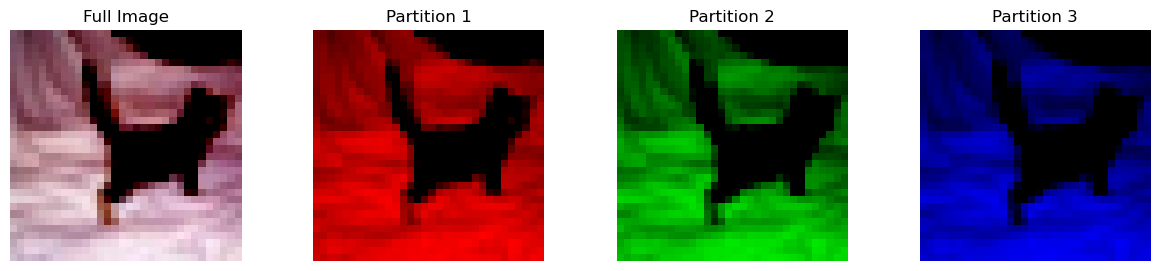

In [5]:
# Viewing how every image will be partitioned
def view_part_img():
    cifar_images = DataLoader(cifar_train, batch_size=1, shuffle=True)
    for batch_idx, (images, labels) in enumerate(cifar_images):
        print(f'Image {batch_idx + 1}')
        partitions_all_channels, partitions_one_channel = partition_image_vf(images, num_partitions=3)
        fig, axes = plt.subplots(1, len(partitions_all_channels)+1, figsize=((len(partitions_all_channels)+2) * 3, 3))
        axes[0].imshow(images[0].permute(1, 2, 0).numpy())
        axes[0].axis('off')
        axes[0].set_title(f'Full Image')
        for i in range(len(partitions_all_channels)):
            axes[i+1].imshow(partitions_all_channels[i].permute(1, 2, 0).clamp(0, 1).cpu().numpy())
            axes[i+1].axis('off')
            axes[i+1].set_title(f'Partition {i+1}')
        plt.show()
        if batch_idx == 0:
            break
view_part_img()

# View Train

All channels
Train batch images details: torch.Size([32, 3, 32, 32]) <class 'torch.Tensor'>
Train batch labels details: torch.Size([32]) <class 'torch.Tensor'>
Channel 0 tensor([[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
        [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
        [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
        ...,
        [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
        [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
        [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
       device='cuda:0') tensor([[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
        [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
        [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
        ...,
        [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
        [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
        [

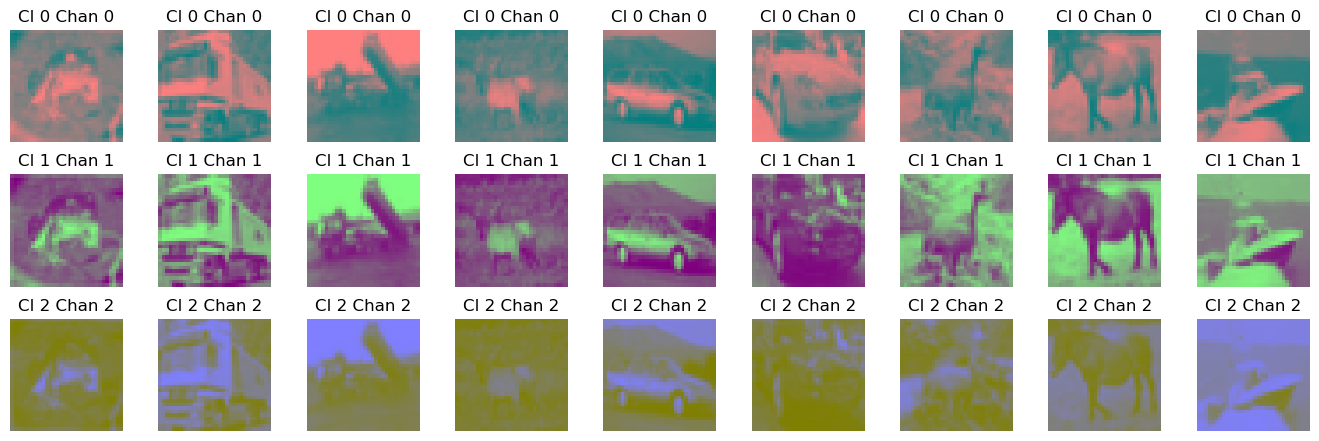

One channel
Train batch images details: torch.Size([32, 1, 32, 32]) <class 'torch.Tensor'>
Train batch labels details: torch.Size([32]) <class 'torch.Tensor'>


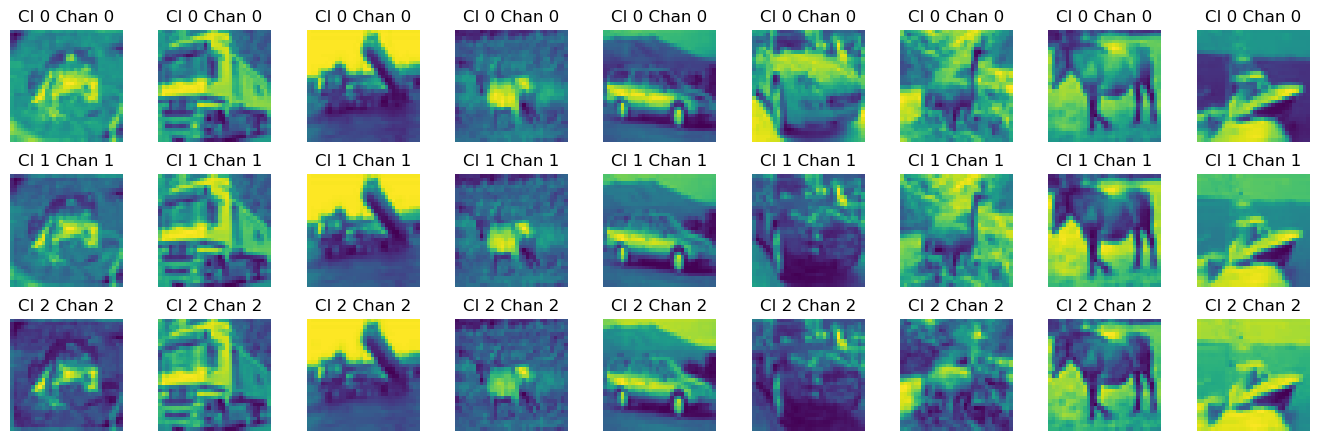

In [6]:
def view_train_all():
    print("All channels")
    batch = next(iter(all_channel_trainloaders[0]))
    images, labels = batch[0], batch[1]
    print("Train batch images details:", images.shape, type(images))
    print("Train batch labels details:", labels.shape, type(labels))

    # # Checking populated channels
    ver_partitions = len(all_channel_trainloaders)
    for i in range(ver_partitions):
        # print("Train loader", i)
        batch = next(iter(all_channel_trainloaders[i]))
        batch_ = next(iter(one_channel_trainloaders[i]))
        images, labels = batch[0], batch[1]
        images_, labels_ = batch_[0], batch_[1]
        print("Channel 0", images[0,0,:], images_[0,0,:])
        print("Channel 1", images[0,1,:], images_[0,0,:])
        print("Channel 2", images[0,2,:], images_[0,0,:])

    # # Create a figure and a grid of subplots
    partitions = len(all_channel_trainloaders)
    fig, axs = plt.subplots(partitions, 9, figsize=(9*1.5, 1.5*partitions))
    for i in range(len(axs)):
        # print(i)
        for j in range(len(axs[i])):
            batch = next(iter(all_channel_trainloaders[i]))
            images, labels = batch[0], batch[1]
            images = images.permute(0, 2, 3, 1).cpu().numpy()
            images = images / 2 + 0.5
            axs[i, j].imshow(images[j])
            axs[i, j].axis("off")
            axs[i, j].set_title(f'Cl {i} Chan {CHANNEL_DICT[i]}')

    # Show the plot
    fig.tight_layout()
    plt.show()

def view_train_one():
    print("One channel")
    batch = next(iter(one_channel_trainloaders[0]))
    images, labels = batch[0], batch[1]
    print("Train batch images details:", images.shape, type(images))
    print("Train batch labels details:", labels.shape, type(labels))

    # # Create a figure and a grid of subplots
    partitions = len(one_channel_trainloaders)
    fig, axs = plt.subplots(partitions, 9, figsize=(9*1.5, 1.5*partitions))
    for i in range(len(axs)):
        # print(i)
        for j in range(len(axs[i])):
            batch = next(iter(one_channel_trainloaders[i]))
            images, labels = batch[0], batch[1]
            images = images.permute(0, 2, 3, 1).cpu().numpy()
            images = images / 2 + 0.5
            axs[i, j].imshow(images[j])
            axs[i, j].axis("off")
            axs[i, j].set_title(f'Cl {i} Chan {CHANNEL_DICT[i]}')

    # Show the plot
    fig.tight_layout()
    plt.show()

view_train_all()
view_train_one()

# View Test

All channels
Test batch images details: torch.Size([32, 3, 32, 32]) <class 'torch.Tensor'>
Test batch labels details: torch.Size([32]) <class 'torch.Tensor'>
Test loader 0
Channel 0 tensor([[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
        [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
        [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
        ...,
        [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
        [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
        [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],
       device='cuda:0') tensor([[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
        [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
        [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
        ...,
        [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
        [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431

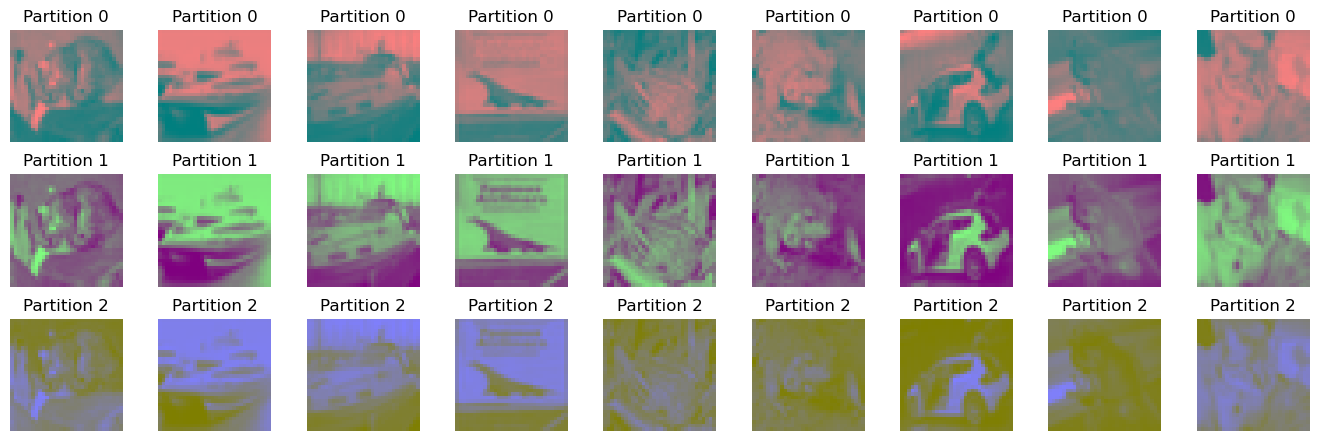

One channel
Test batch images details: torch.Size([32, 1, 32, 32]) <class 'torch.Tensor'>
Test batch labels details: torch.Size([32]) <class 'torch.Tensor'>


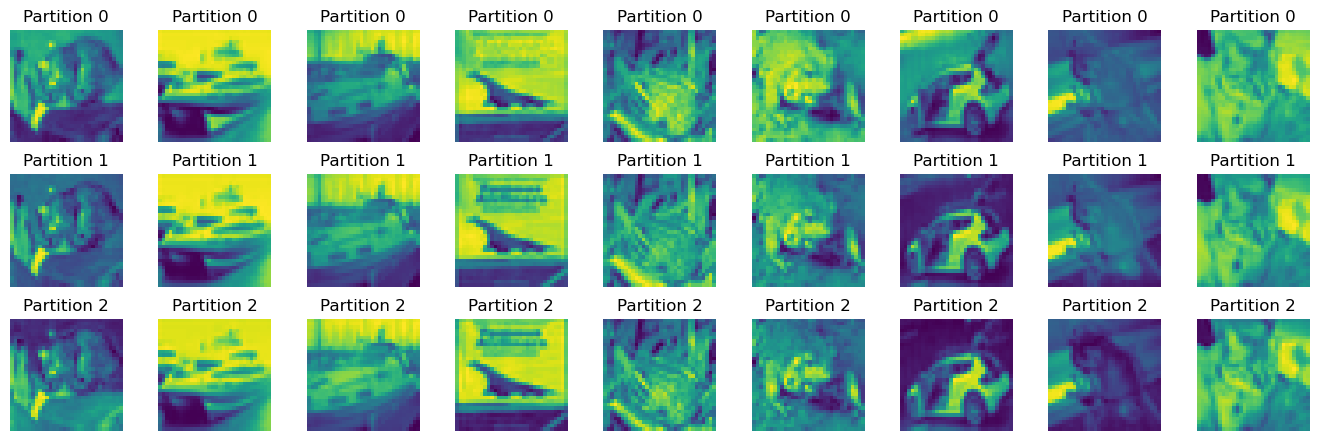

Test batch images details: torch.Size([32, 3, 32, 32]) <class 'torch.Tensor'>
Test batch labels details: torch.Size([32]) <class 'torch.Tensor'>


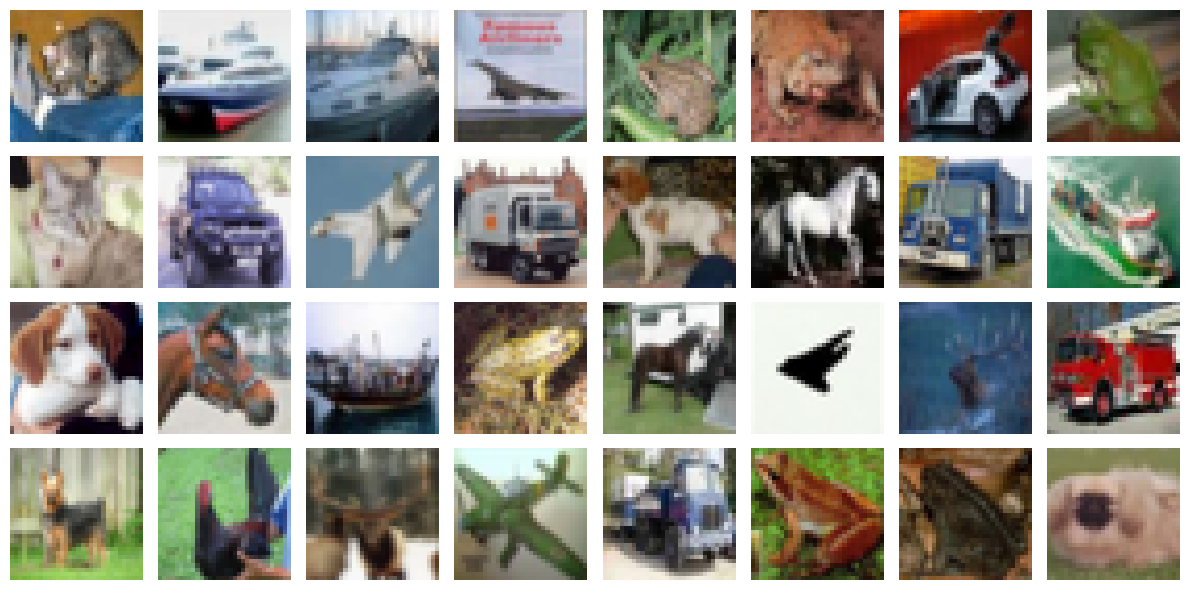

In [7]:
def view_test_all():
    print("All channels")
    batch = next(iter(all_channel_testloaders[0]))
    images, labels = batch[0], batch[1]
    print("Test batch images details:", images.shape, type(images))
    print("Test batch labels details:", labels.shape, type(labels))

    # Checking populated channels
    ver_partitions = len(all_channel_testloaders)
    for i in range(ver_partitions):
        print("Test loader", i)
        batch = next(iter(all_channel_testloaders[i]))
        batch_ = next(iter(one_channel_testloaders[i]))
        images, labels = batch[0], batch[1]
        images_, labels_ = batch_[0], batch_[1]
        print("Channel 0", images[0,0,:], images_[0,0,:])
        print("Channel 1", images[0,1,:], images_[0,0,:])
        print("Channel 2", images[0,2,:], images_[0,0,:])

    # # Create a figure and a grid of subplots
    partitions = len(all_channel_testloaders)
    fig, axs = plt.subplots(partitions, 9, figsize=(9*1.5, 1.5*partitions))
    for i in range(len(axs)):
        # print(i)
        for j in range(len(axs[i])):
            batch = next(iter(all_channel_testloaders[i]))
            images, labels = batch[0], batch[1]
            images = images.permute(0, 2, 3, 1).cpu().numpy()
            images = images / 2 + 0.5
            axs[i, j].imshow(images[j])
            axs[i, j].axis("off")
            axs[i, j].set_title(f'Partition {i}')

    # Show the plot
    fig.tight_layout()
    plt.show()

def view_test_one():
    print("One channel")
    batch = next(iter(one_channel_testloaders[0]))
    images, labels = batch[0], batch[1]
    print("Test batch images details:", images.shape, type(images))
    print("Test batch labels details:", labels.shape, type(labels))

    # # Create a figure and a grid of subplots
    partitions = len(one_channel_testloaders)
    fig, axs = plt.subplots(partitions, 9, figsize=(9*1.5, 1.5*partitions))
    for i in range(len(axs)):
        # print(i)
        for j in range(len(axs[i])):
            batch = next(iter(one_channel_testloaders[i]))
            images, labels = batch[0], batch[1]
            images = images.permute(0, 2, 3, 1).cpu().numpy()
            images = images / 2 + 0.5
            axs[i, j].imshow(images[j])
            axs[i, j].axis("off")
            axs[i, j].set_title(f'Partition {i}')

    # Show the plot
    fig.tight_layout()
    plt.show()

    # print("Not partitioned channels")
    batch = next(iter(testloader))
    images, labels = batch[0], batch[1]
    print("Test batch images details:", images.shape, type(images))
    print("Test batch labels details:", labels.shape, type(labels))

    images = images.permute(0, 2, 3, 1).cpu().numpy()
    images = images / 2 + 0.5
    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(4, 8, figsize=(12, 6))
    # Loop over the images and plot them
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        # ax.set_title(trainloaders[0].dataset.features[1].int2str([labels[i]])[0])
        ax.axis("off")

    # Show the plot
    fig.tight_layout()
    plt.show()

view_test_all()
view_test_one()

# Neural Networks, Train and Test Functions, and Parameter Get and Set Functions

In [8]:
class SingleChannelNet(nn.Module):
    def __init__(self):
        super(SingleChannelNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class FusedModel(nn.Module):
    def __init__(self):
        super(FusedModel, self).__init__()
        self.models = nn.ModuleList()
        for i in range(NUM_VERT_PARTITIONS):
            self.models.append(SingleChannelNet())
        self.channels = NUM_VERT_PARTITIONS

    def forward(self, x):
        outputs = []
        channel_splits = torch.split(x, 1, dim=1)
        for i, channel in enumerate(channel_splits):
            outputs.append(self.models[i](channel))
        stacked_outputs = torch.stack(outputs, dim=0)
        averaged_output = torch.mean(stacked_outputs, dim=0)
        return averaged_output

# Print details of parameters
def print_model_deets():
    model = SingleChannelNet().to(DEVICE)
    state_dict = model.state_dict()
    print("SINGLE CHANNEL MODEL")
    print(str(model), "Parameters:", len(state_dict))
    for name, param in state_dict.items():
        print(f"Parameter name: {name}, Shape: {param.shape}")
    model = FusedModel().to(DEVICE)
    state_dict = model.state_dict()
    print("FUSED MODEL")
    print(str(model), "Parameters:", len(state_dict))
    for name, param in state_dict.items():
        print(f"Parameter name: {name}, Shape: {param.shape}")
print_model_deets()

def train(net, trainloader, epochs: int, verbose=False, alpha=0):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1} | Train | Loss {epoch_loss} | Accuracy {epoch_acc}")
    training_loss, training_accuracy = test(net, trainloader)
    print(f"Single Client | Train | Loss {training_loss} | Accuracy {training_accuracy}")
    return training_loss , training_accuracy

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    print(f"Single Client | Test | Loss {loss} | Accuracy {accuracy}")
    return loss, accuracy

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

SINGLE CHANNEL MODEL
SingleChannelNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) Parameters: 10
Parameter name: conv1.weight, Shape: torch.Size([6, 1, 5, 5])
Parameter name: conv1.bias, Shape: torch.Size([6])
Parameter name: conv2.weight, Shape: torch.Size([16, 6, 5, 5])
Parameter name: conv2.bias, Shape: torch.Size([16])
Parameter name: fc1.weight, Shape: torch.Size([120, 400])
Parameter name: fc1.bias, Shape: torch.Size([120])
Parameter name: fc2.weight, Shape: torch.Size([84, 120])
Parameter name: fc2.bias, Shape: torch.Size([84])
Parameter name: fc3.weight, Shape: torch.Size([10, 84])
Parameter name: fc3.bias, Shape: torch.Size([10])
FUSED M

# Flower Client and Client Engine

In [9]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader, node_id):
        self.cid = cid
        self.net = net.to(DEVICE)
        self.channel = CHANNEL_DICT[int(cid)]
        self.trainloader = trainloader
        self.valloader = valloader
        self.node_id = node_id

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"STEP 2: fit [client: {self.cid} channel: {self.channel} Node: {self.node_id}, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {'train-loss': float(loss), 'train-accuracy': float(accuracy)}

    def evaluate(self, parameters, config):
        print(f"STEP 6: evaluate [Client {self.cid}], config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"test-accuracy": float(accuracy)}

def client_fn(context: Context) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    net = SingleChannelNet().to(DEVICE)

    # Get cid from context and assign loaders
    cid = context.node_config.get("partition-id", context.node_id)
    trainloader = one_channel_trainloaders[int(cid)]
    valloader = one_channel_testloaders[CHANNEL_DICT[int(cid)]]

    # Create a  single Flower client representing a single organization
    return FlowerClient(cid, net, trainloader, valloader, context.node_id).to_client()

# Strategy and Simulation

In [10]:

class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = NUM_CLIENTS,
        min_evaluate_clients: int = NUM_CLIENTS,
        min_available_clients: int = NUM_CLIENTS,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedCustom"

    # STEP 0: initialize global model (happens once)
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        print("STEP 0: initialize the global model")
        net = FusedModel().to(DEVICE)
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    # STEP 1: configure the fit round
    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        print(f'STEP 1: configure the next fit round {server_round}/{NUM_ROUNDS}')
        # Sample clients
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        arrays = parameters_to_ndarrays(parameters)
        arrays_dict = {channel: [] for channel in range(NUM_VERT_PARTITIONS)}
        part_size = math.floor(int(len(arrays) / NUM_VERT_PARTITIONS))
        start = 0
        for channel in range(NUM_VERT_PARTITIONS):
            arrays_dict[channel] = arrays[start:start+part_size]
            start = start+part_size

        fit_configurations = []
        for idx, client in enumerate(clients):
            channel = CHANNEL_DICT[int(client.partition_id)]
            # print("client id", client.partition_id, "channel", channel, "node id", client.node_id)
            config = {
            "local_epochs": LOCAL_EPOCHS,
            }
            fit_configurations.append((client, FitIns(ndarrays_to_parameters(arrays_dict[channel]), config)))

        return fit_configurations

    # STEP 2: fit all clients
    # STEP 3: aggregate client parameters
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        print("STEP 3: aggregate client parameters")
        weights_by_channels = {channel_id: [] for channel_id in range(NUM_VERT_PARTITIONS)}
        for cl, fit_res in results:
            channel = CHANNEL_DICT[cl.partition_id]
            weights_by_channels[channel].append((parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples))

        ndarrays = []
        for key in sorted(weights_by_channels.keys()):
            ndarrays.append(aggregate(weights_by_channels[key]))
        ndarrays = sum(ndarrays, [])
        parameters_aggregated = ndarrays_to_parameters(ndarrays)

        # Extracting other metrics for every client
        train_accuracies = [] # to store accuracies
        train_losses = [] # to store accuracies
        examples = [] # to store num_examples
        for _, fit_res in results:
            train_accuracies.append(fit_res.metrics['train-accuracy'])
            train_losses.append(fit_res.metrics['train-loss'])
            examples.append(fit_res.num_examples)

        # Aggregated client training loss and accuracy
        aggregated_train_losses = [accuracy*example for accuracy,example in list(zip(train_losses, examples))]
        aggregated_average_train_loss = sum(aggregated_train_losses) / sum(examples)
        aggregated_train_accuracies = [accuracy*example for accuracy,example in list(zip(train_accuracies, examples))]
        aggregated_average_train_accuracy = sum(aggregated_train_accuracies) / sum(examples)

        # Return metrics
        metrics_aggregated = {'aggregated_client_train_loss': aggregated_average_train_loss, "aggregated_client_train_accuracy": aggregated_average_train_accuracy}
        print(f"Clients | Train |  Loss {aggregated_average_train_loss} / Accuracy {aggregated_average_train_accuracy}")
        return parameters_aggregated, metrics_aggregated


    # STEP 5: configure evaluate round
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        print("STEP 5: configure the next evaluate round")
        if self.fraction_evaluate == 0.0:
            return []
        config = {}

        arrays = parameters_to_ndarrays(parameters)
        arrays_dict = {channel: [] for channel in range(NUM_VERT_PARTITIONS)}
        part_size = math.floor(int(len(arrays) / NUM_VERT_PARTITIONS))
        start = 0
        for channel in range(NUM_VERT_PARTITIONS):
            arrays_dict[channel] = arrays[start:start+part_size]
            start = start+part_size
        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        ret = []
        for client in clients:
            channel = CHANNEL_DICT[int(client.partition_id)]
            ret.append((client, EvaluateIns(ndarrays_to_parameters(arrays_dict[channel]), config)))
        return ret

    # STEP 4: evaluate the global model on the test dataset
    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evaluation function."""
        print("STEP 4: evaluate the global model on the test dataset")
        net = FusedModel().to(DEVICE)
        set_parameters(net, parameters_to_ndarrays(parameters))  # Update model with the latest parameters
        
        loss, accuracy = test(net, testloader)
        print(f"Global | Test | Loss {loss} / Accuracy {accuracy}")
        return loss, {"global-test-accuracy": accuracy}

    # STEP 6: evaluate clients
    # STEP 7: aggregate client metrics
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        print("STEP 7: aggregate client metrics")
        if not results:
            return None, {}
        # Weighted average loss
        loss_aggregated = weighted_loss_avg([(evaluate_res.num_examples, evaluate_res.loss) for _, evaluate_res in results])

        # Extracting other metrics for every client
        accuracies = [] # to store accuracies
        examples = [] # to store num_examples
        for _, evaluate_res in results:
            accuracies.append(evaluate_res.metrics['test-accuracy'])
            examples.append(evaluate_res.num_examples)

        # Weighted average accuracy
        aggregated_test_accuracies = [accuracy*example for accuracy,example in list(zip(accuracies, examples))]
        aggregated_test_accuracy = sum(aggregated_test_accuracies) / sum(examples)

        # Return metrics
        metrics_aggregated = {'aggregated_client_test_loss': loss_aggregated, "aggregated_client_test_accuracy": aggregated_test_accuracy}
        print(f"Clients | Test | Loss {loss_aggregated} / Accuracy {aggregated_test_accuracy}")
        return loss_aggregated, metrics_aggregated

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    client_resources = {"num_cpus": 1, "num_gpus": 1.0} # Assigning an entire GPU for each client

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=FedCustom(),
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=6, no round_timeout
2024-08-20 22:48:36,099	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 53434208256.0, 'GPU': 2.0, 'accelerator_type:G': 1.0, 'node:192.168.1.146': 1.0, 'memory': 114679819264.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters


STEP 0: initialize the global model
STEP 4: evaluate the global model on the test dataset


INFO :      initial parameters (loss, other metrics): 0.07207615413665772, {'global-test-accuracy': 0.0999}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.07207615413665772 | Accuracy 0.0999
Global | Test | Loss 0.07207615413665772 / Accuracy 0.0999
STEP 1: configure the next fit round 1/6


(ClientAppActor pid=435893) /home/mujtaba/miniconda3/envs/ftl/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(ClientAppActor 

(ClientAppActor pid=435892) STEP 2: fit [client: 0 channel: 0 Node: 5890627810775373293, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.03512831124544143 | Accuracy 0.60854
(ClientAppActor pid=435892) Single Client | Train | Loss 0.03512831124544143 | Accuracy 0.60854


(ClientAppActor pid=435892) /home/mujtaba/miniconda3/envs/ftl/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(ClientAppActor 

(ClientAppActor pid=435892) STEP 2: fit [client: 1 channel: 1 Node: 6341989014342012542, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.03381874379694462 | Accuracy 0.62198
(ClientAppActor pid=435892) Single Client | Train | Loss 0.03381874379694462 | Accuracy 0.62198
(ClientAppActor pid=435893) STEP 2: fit [client: 2 channel: 2 Node: 8739182656143936346, config: {'local_epochs': 5}


INFO :      aggregate_fit: received 3 results and 0 failures


STEP 3: aggregate client parameters
Clients | Train |  Loss 0.03445640549163024 / Accuracy 0.6126866666666667
STEP 4: evaluate the global model on the test dataset
(ClientAppActor pid=435893) Single Client | Test | Loss 0.03442216143250466 | Accuracy 0.60754
(ClientAppActor pid=435893) Single Client | Train | Loss 0.03442216143250466 | Accuracy 0.60754


INFO :      fit progress: (1, 0.03306910614967346, {'global-test-accuracy': 0.6242}, 241.38129356098943)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.03306910614967346 | Accuracy 0.6242
Global | Test | Loss 0.03306910614967346 / Accuracy 0.6242
STEP 5: configure the next evaluate round


(ClientAppActor pid=435893) /home/mujtaba/miniconda3/envs/ftl/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(ClientAppActor 

(ClientAppActor pid=435892) STEP 6: evaluate [Client 0], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.039800472629070285 | Accuracy 0.5595
(ClientAppActor pid=435892) STEP 6: evaluate [Client 1], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.03818529652953148 | Accuracy 0.5719


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


STEP 7: aggregate client metrics
Clients | Test | Loss 0.038831493308146794 / Accuracy 0.5634333333333333
STEP 1: configure the next fit round 2/6
(ClientAppActor pid=435893) STEP 6: evaluate [Client 2], config: {}
(ClientAppActor pid=435893) Single Client | Test | Loss 0.03850871076583862 | Accuracy 0.5589
(ClientAppActor pid=435892) STEP 2: fit [client: 1 channel: 1 Node: 6341989014342012542, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.02882980436861515 | Accuracy 0.67988
(ClientAppActor pid=435892) Single Client | Train | Loss 0.02882980436861515 | Accuracy 0.67988
(ClientAppActor pid=435892) STEP 2: fit [client: 0 channel: 0 Node: 5890627810775373293, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.029557507038116455 | Accuracy 0.67144
(ClientAppActor pid=435892) Single Client | Train | Loss 0.029557507038116455 | Accuracy 0.67144
(ClientAppActor pid=435893) STEP 2: fit [client: 2 channel: 2 Node: 87391

INFO :      aggregate_fit: received 3 results and 0 failures


STEP 3: aggregate client parameters
Clients | Train |  Loss 0.02931485066990058 / Accuracy 0.67102
STEP 4: evaluate the global model on the test dataset
(ClientAppActor pid=435893) Single Client | Test | Loss 0.029557240602970124 | Accuracy 0.66174
(ClientAppActor pid=435893) Single Client | Train | Loss 0.029557240602970124 | Accuracy 0.66174


INFO :      fit progress: (2, 0.030238559377193452, {'global-test-accuracy': 0.6565}, 647.0192694529833)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.030238559377193452 | Accuracy 0.6565
Global | Test | Loss 0.030238559377193452 / Accuracy 0.6565
STEP 5: configure the next evaluate round
(ClientAppActor pid=435892) STEP 6: evaluate [Client 1], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.038183744513988496 | Accuracy 0.5906
(ClientAppActor pid=435892) STEP 6: evaluate [Client 0], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.039140808480978014 | Accuracy 0.5818


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=435893) STEP 6: evaluate [Client 2], config: {}
(ClientAppActor pid=435893) Single Client | Test | Loss 0.03754587864279747 | Accuracy 0.5846
STEP 7: aggregate client metrics
Clients | Test | Loss 0.03829014387925466 / Accuracy 0.5856666666666667
STEP 1: configure the next fit round 3/6
(ClientAppActor pid=435892) STEP 2: fit [client: 2 channel: 2 Node: 8739182656143936346, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.02752051522433758 | Accuracy 0.68594
(ClientAppActor pid=435892) Single Client | Train | Loss 0.02752051522433758 | Accuracy 0.68594
(ClientAppActor pid=435892) STEP 2: fit [client: 0 channel: 0 Node: 5890627810775373293, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.029547521156072617 | Accuracy 0.6731
(ClientAppActor pid=435892) Single Client | Train | Loss 0.029547521156072617 | Accuracy 0.6731
(ClientAppActor pid=435893) STEP 2: fit [client: 1 channel: 1 Node: 63419890

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=435893) Single Client | Test | Loss 0.025786614553332327 | Accuracy 0.71236
(ClientAppActor pid=435893) Single Client | Train | Loss 0.025786614553332327 | Accuracy 0.71236
STEP 3: aggregate client parameters
Clients | Train |  Loss 0.027618216977914178 / Accuracy 0.6904666666666667
STEP 4: evaluate the global model on the test dataset


INFO :      fit progress: (3, 0.030616714030504227, {'global-test-accuracy': 0.6634}, 1064.7501867799729)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.030616714030504227 | Accuracy 0.6634
Global | Test | Loss 0.030616714030504227 / Accuracy 0.6634
STEP 5: configure the next evaluate round
(ClientAppActor pid=435892) STEP 6: evaluate [Client 2], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.040365060436725615 | Accuracy 0.5797
(ClientAppActor pid=435892) STEP 6: evaluate [Client 1], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.040647041940689084 | Accuracy 0.5933
(ClientAppActor pid=435893) STEP 6: evaluate [Client 0], config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


STEP 7: aggregate client metrics
Clients | Test | Loss 0.04165080527464549 / Accuracy 0.5791999999999999
STEP 1: configure the next fit round 4/6
(ClientAppActor pid=435893) Single Client | Test | Loss 0.04394031344652176 | Accuracy 0.5646
(ClientAppActor pid=435892) STEP 2: fit [client: 2 channel: 2 Node: 8739182656143936346, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.025342173519730567 | Accuracy 0.70882
(ClientAppActor pid=435892) Single Client | Train | Loss 0.025342173519730567 | Accuracy 0.70882
(ClientAppActor pid=435892) STEP 2: fit [client: 1 channel: 1 Node: 6341989014342012542, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.02444394243746996 | Accuracy 0.7254
(ClientAppActor pid=435892) Single Client | Train | Loss 0.02444394243746996 | Accuracy 0.7254
(ClientAppActor pid=435893) STEP 2: fit [client: 0 channel: 0 Node: 5890627810775373293, config: {'local_epochs': 5}


INFO :      aggregate_fit: received 3 results and 0 failures


STEP 3: aggregate client parameters
Clients | Train |  Loss 0.025396384761134785 / Accuracy 0.7129333333333334
STEP 4: evaluate the global model on the test dataset
(ClientAppActor pid=435893) Single Client | Test | Loss 0.026403038326203825 | Accuracy 0.70458
(ClientAppActor pid=435893) Single Client | Train | Loss 0.026403038326203825 | Accuracy 0.70458


INFO :      fit progress: (4, 0.031050866162776948, {'global-test-accuracy': 0.6687}, 1437.531125102978)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.031050866162776948 | Accuracy 0.6687
Global | Test | Loss 0.031050866162776948 / Accuracy 0.6687
STEP 5: configure the next evaluate round
(ClientAppActor pid=435892) STEP 6: evaluate [Client 0], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.04584855356812477 | Accuracy 0.5606
(ClientAppActor pid=435892) STEP 6: evaluate [Client 1], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.0446978418469429 | Accuracy 0.5839


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


(ClientAppActor pid=435893) STEP 6: evaluate [Client 2], config: {}
STEP 7: aggregate client metrics
Clients | Test | Loss 0.04442816389401753 / Accuracy 0.5747
STEP 1: configure the next fit round 5/6
(ClientAppActor pid=435893) Single Client | Test | Loss 0.04273809626698494 | Accuracy 0.5796
(ClientAppActor pid=435892) STEP 2: fit [client: 1 channel: 1 Node: 6341989014342012542, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.025313392843008042 | Accuracy 0.72086
(ClientAppActor pid=435892) Single Client | Train | Loss 0.025313392843008042 | Accuracy 0.72086
(ClientAppActor pid=435892) STEP 2: fit [client: 0 channel: 0 Node: 5890627810775373293, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.024688848367333413 | Accuracy 0.72354
(ClientAppActor pid=435892) Single Client | Train | Loss 0.024688848367333413 | Accuracy 0.72354
(ClientAppActor pid=435893) STEP 2: fit [client: 2 channel: 2 Node: 8739182656143936

INFO :      aggregate_fit: received 3 results and 0 failures


STEP 3: aggregate client parameters
Clients | Train |  Loss 0.025243358379801115 / Accuracy 0.7175866666666666
STEP 4: evaluate the global model on the test dataset
(ClientAppActor pid=435893) Single Client | Test | Loss 0.02572783392906189 | Accuracy 0.70836
(ClientAppActor pid=435893) Single Client | Train | Loss 0.02572783392906189 | Accuracy 0.70836


INFO :      fit progress: (5, 0.03286393108963966, {'global-test-accuracy': 0.6645}, 1904.2898732929898)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.03286393108963966 | Accuracy 0.6645
Global | Test | Loss 0.03286393108963966 / Accuracy 0.6645
STEP 5: configure the next evaluate round
(ClientAppActor pid=435892) STEP 6: evaluate [Client 2], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.04770452790260315 | Accuracy 0.5651
(ClientAppActor pid=435892) STEP 6: evaluate [Client 1], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.050779222500324246 | Accuracy 0.573
(ClientAppActor pid=435893) STEP 6: evaluate [Client 0], config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


STEP 7: aggregate client metrics
Clients | Test | Loss 0.04940494940082232 / Accuracy 0.5678666666666665
STEP 1: configure the next fit round 6/6
(ClientAppActor pid=435893) Single Client | Test | Loss 0.04973109779953957 | Accuracy 0.5655
(ClientAppActor pid=435892) STEP 2: fit [client: 2 channel: 2 Node: 8739182656143936346, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.025939228566884995 | Accuracy 0.70888
(ClientAppActor pid=435892) Single Client | Train | Loss 0.025939228566884995 | Accuracy 0.70888
(ClientAppActor pid=435892) STEP 2: fit [client: 1 channel: 1 Node: 6341989014342012542, config: {'local_epochs': 5}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.02953061578810215 | Accuracy 0.69788
(ClientAppActor pid=435892) Single Client | Train | Loss 0.02953061578810215 | Accuracy 0.69788
(ClientAppActor pid=435893) STEP 2: fit [client: 0 channel: 0 Node: 5890627810775373293, config: {'local_epochs': 5}


INFO :      aggregate_fit: received 3 results and 0 failures


STEP 3: aggregate client parameters
Clients | Train |  Loss 0.026618924189805986 / Accuracy 0.7121000000000001
STEP 4: evaluate the global model on the test dataset
(ClientAppActor pid=435893) Single Client | Test | Loss 0.02438692821443081 | Accuracy 0.72954
(ClientAppActor pid=435893) Single Client | Train | Loss 0.02438692821443081 | Accuracy 0.72954


INFO :      fit progress: (6, 0.035269453099370005, {'global-test-accuracy': 0.659}, 2276.598501418979)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)


Single Client | Test | Loss 0.035269453099370005 | Accuracy 0.659
Global | Test | Loss 0.035269453099370005 / Accuracy 0.659
STEP 5: configure the next evaluate round
(ClientAppActor pid=435892) STEP 6: evaluate [Client 0], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.05351549717783928 | Accuracy 0.5588
(ClientAppActor pid=435892) STEP 6: evaluate [Client 1], config: {}
(ClientAppActor pid=435892) Single Client | Test | Loss 0.06095151384472847 | Accuracy 0.5519
(ClientAppActor pid=435893) STEP 6: evaluate [Client 2], config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 6 round(s) in 2450.39s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.038831493308146794
INFO :      		round 2: 0.03829014387925466
INFO :      		round 3: 0.04165080527464549
INFO :      		round 4: 0.04442816389401753
INFO :      		round 5: 0.04940494940082232
INFO :      		round 6: 0.05563609829346339
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07207615413665772
INFO :      		round 1: 0.03306910614967346
INFO :      		round 2: 0.030238559377193452
INFO :      		round 3: 0.030616714030504227
INFO :      		round 4: 0.031050866162776948
INFO :      		round 5: 0.03286393108963966
INFO :      		round 6: 0.035269453099370005
INFO :      	History (metrics, distributed, fit):
INFO :      	{'aggregated_client_train_accuracy': [(1, 0.6126866666666667),
INFO :      	                                      (2, 0.67102),
INFO :      

STEP 7: aggregate client metrics
Clients | Test | Loss 0.05563609829346339 / Accuracy 0.5550666666666666


History (loss, distributed):
	round 1: 0.038831493308146794
	round 2: 0.03829014387925466
	round 3: 0.04165080527464549
	round 4: 0.04442816389401753
	round 5: 0.04940494940082232
	round 6: 0.05563609829346339
History (loss, centralized):
	round 0: 0.07207615413665772
	round 1: 0.03306910614967346
	round 2: 0.030238559377193452
	round 3: 0.030616714030504227
	round 4: 0.031050866162776948
	round 5: 0.03286393108963966
	round 6: 0.035269453099370005
History (metrics, distributed, fit):
{'aggregated_client_train_accuracy': [(1, 0.6126866666666667),
                                      (2, 0.67102),
                                      (3, 0.6904666666666667),
                                      (4, 0.7129333333333334),
                                      (5, 0.7175866666666666),
                                      (6, 0.7121000000000001)],
 'aggregated_client_train_loss': [(1, 0.03445640549163024),
                                  (2, 0.02931485066990058),
                      

(ClientAppActor pid=435893) Single Client | Test | Loss 0.052441283857822416 | Accuracy 0.5545


*** SIGTERM received at time=1724193429 on cpu 24 ***
PC: @     0x7fc6ab5e4e2e  (unknown)  epoll_wait
    @     0x7fc6ab501520  (unknown)  (unknown)
[2024-08-20 23:37:09,141 E 433730 433730] logging.cc:361: *** SIGTERM received at time=1724193429 on cpu 24 ***
[2024-08-20 23:37:09,141 E 433730 433730] logging.cc:361: PC: @     0x7fc6ab5e4e2e  (unknown)  epoll_wait
[2024-08-20 23:37:09,141 E 433730 433730] logging.cc:361:     @     0x7fc6ab501520  (unknown)  (unknown)
